# Cuts on the Right Handed Neutrino Decay

This notebook will contain some of the elementary cuts applied on the monoleptonic channel of the right handed neutrino decay.

The signal and the background for the process are as follows :
- Signal
    - n2n2 <br>
$p p → Z' → N_r N_r, N_r → Z v_l → j j v_l, N_r → W l → l j j$

- Background 
    - ttbar <br>
$p p → t t, t → W b, W → j j$

    - wmp <br>
$ p p → W → l v_l$

    - wpmp <br>
$ p p → W+ W- → l v_l j j$

    - zwmp <br>
$ p p → Z W, Z → j j, W → l v_l $

    - zzjj <br>
$ p p → Z Z, Z → j j $


## Hyperparameters used

### Testing parameters :
- gX = 0.1
- gN = 0.1
- Zn2 = 2.838
- Mzp = 3000 GeV
- Beam Energy = 14 TeV
- Default Jet Matching Settings

### Generation Level Cuts :
- Minimum $P_T$ of leading Lepton = 120
- Minimum $P_T$ of leading Jet = 120
- Minimum $\eta_j$ = -2
- Maximum $\eta_j$ = 2

### Analysis Level Cuts (Using Topology):
- Minimum Number of Leptons = 1
- Minimum number of Narrow Jets = 2
- Minimum Number of Fat Jets = 2

## Preprocessing

Preprocessing the python files to get the imports required and the Machine Learning to work properly

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style as mpl
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from sklearn.utils import shuffle
from PIL import ImageFont
import datetime
import visualkeras
import gc

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [4]:
import tensorflow as tf
%load_ext tensorboard

In [5]:
%matplotlib inline
mpl.use('seaborn')

### Hyperparameters

In [6]:
mn2 = 1000
prop_seed = 123
train_div = 0.5
back_callback_dir = "/home2/kalp_shah/neutrino/codes/ml/backup/dnn"
log_folder = "logs/dnn"
model_dir = "/home2/kalp_shah/neutrino/datasets/model/"
sig_epoch = {'test' : [], 'complete' : []}
model_max = Sequential()
max_sig = 0

2022-05-01 18:46:40.239653: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-05-01 18:46:40.239715: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: gnode14
2022-05-01 18:46:40.239727: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: gnode14
2022-05-01 18:46:40.239858: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 440.95.1
2022-05-01 18:46:40.239891: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 440.95.1
2022-05-01 18:46:40.239899: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 440.95.1
2022-05-01 18:46:40.240539: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in pe

In [7]:
!rm -rf /home2/kalp_shah/neutrino/codes/ml/backup/dnn
!rm -rf logs/dnn

## Calculating the Cross Section

The calculation of the cross section is done as follows :

$\sigma_p = \sigma_{LO} \frac{\sigma_{MGcuts}}{\sigma_{MGno-cuts}} $

In [8]:
n2n2_cs = {500  : 5.13*1e-4,
           750  : 3.83*1e-4,
           1000 : 2.41*1e-4,
           1250 : 9.56*1e-5,
           1400 : 4.74*1e-5}

In [9]:
files = ['ttbar','wmp','wpwm','zwpm','n2n2']

cs_lo_k = {
            'ttbar':988.57,
            'wmp'  :1.95*1e5,
            'wpwm' :124.31,
            'zwpm' :51.82,
            'n2n2' :1
          }

br_ratio = {'ttbar':0.67*(1-0.67)*2,
            'wmp'  :(1-0.67),
            'wpwm' :(1-0.67)*0.67*2,
            'zwpm' :0.7*(1-0.67),
            'n2n2' :1
           }

cs_nmg = {'ttbar':393.30,
          'wmp'  :7.865*1e4,
          'wpwm' :74.96,
          'zwpm' :14.28,
          'n2n2' :1
          }

cs_mg = {'ttbar':5.883,
         'wmp':111.5,
         'wpwm':0.944,
         'zwpm':0.2381,
         'n2n2':n2n2_cs[mn2]
         }

cs_pb = []
for f in files:
    cs_pb.append((cs_lo_k[f]*br_ratio[f]*cs_mg[f])/cs_nmg[f])

cs = [i*1e3 for i in cs_pb]
cs_corr = {files[i] : cs[i] for i in range(len(files))}

In [10]:
cs_print = pd.DataFrame([cs_corr.keys(),cs_corr.values()]).T
cs_print.rename(columns = {0:'Process',1:'Cross section (fb)'}, inplace = True)

In [11]:
cs_print.style.hide_index()

Process,Cross section (fb)
ttbar,6538.845366
wmp,91227.272727
wpwm,692.256785
zwpm,199.590826
n2n2,0.241000


## Getting the Data

Finding the amount of events in storage using the following formula :

$ N_{p} = N_{files}*N_{Events-per-files} $

In [12]:
no_of_files = {'ttbar':0,
               'wmp':0,
               'wpwm':0,
               'zwpm':0,
               'n2n2':0
               }

In [13]:
df = []
for f in range(len(files)):
    con_df = []
    
    # The maximum file number 
    for i in range(1,60):
        try:
            if files[f] == 'n2n2':
                con_df.append(pd.read_csv('~/neutrino/datasets/old_signal/n2n2_' + str(mn2) + '/' + files[f] + str(i) + '.csv'))
            else:
                con_df.append(pd.read_csv('~/neutrino/datasets/backgrounds/' + files[f] + str(i) + '.csv'))
            no_of_files[files[f]] += 1
        except:
            pass
    
    df.append(pd.concat(con_df,ignore_index=True))
    df[-1]['type'] = f
    
    if files[f] == "n2n2":
        df[-1]['tag'] = 1
    else:
        df[-1]['tag'] = 0

### Total Number of Files

In [14]:
red_merging = {'ttbar':98159,
               'wmp':96494,
               'wpwm':97633,
               'zwpm':81076,
               'n2n2':int(1e5)
               }

In [15]:
total_events = []

for f in range(len(files)):
    total_events.append(no_of_files[files[f]] * red_merging[files[f]])

In [16]:
nf_print = pd.DataFrame([no_of_files.keys(),total_events]).T
nf_print.rename(columns = {0:'Process',1:'Number of Events'}, inplace = True)

In [17]:
nf_print.style.hide_index()

Process,Number of Events
ttbar,4122678
wmp,3956254
wpwm,3905320
zwpm,3648420
n2n2,3900000


### Sample Output

In [18]:
df[-1].head().style.hide_index()

ptl,etal,energyl,ptj,etaj,energyj,massj,mjj,rjj,rjl,met,n21_1,n21_2,n32_1,n32_2,infl,drfl,type,tag
576.562000,0.232894,592.269000,459.681000,0.248122,475.279000,36.131600,379.243000,1.145090,2.253050,889.067000,0.190804,0.258472,0.517955,0.670891,769.506000,1.864710,4,1
823.599000,-0.418800,896.887000,339.247000,-0.696095,431.789000,77.312200,1052.580000,2.671780,2.072780,1930.330000,0.197178,0.222316,0.468612,0.544453,1113.560000,1.817120,4,1
354.758000,-1.721930,1024.200000,883.807000,-0.817714,1200.200000,98.775000,1764.850000,2.820480,0.922735,3256.570000,0.328865,0.361102,0.409280,0.760725,1015.050000,2.092480,4,1
858.275000,0.386685,923.245000,1258.810000,0.184948,1285.290000,112.015000,1546.480000,1.122830,2.551460,388.116000,0.216487,0.234383,0.308864,0.722296,510.332000,2.045930,4,1
590.040000,-0.006999,590.055000,811.602000,0.445120,897.952000,90.893800,818.864000,1.162910,1.495500,1133.330000,0.172456,0.329166,0.461283,0.696238,351.882000,3.211960,4,1


### Applying Analysis Level Cuts

In [19]:
for i in range(len(df)):
    df[i] = shuffle(df[i])

In [20]:
df_train = []
df_test = []
for df_sub in df:
    df_train.append(df_sub[:int(len(df_sub)/2)])
    df_test.append(df_sub[int(len(df_sub)/2):])

In [21]:
dtset = pd.concat(df,ignore_index=True)
dtset['met'] = np.fabs(dtset['met'])

dtset_train = pd.concat(df_train,ignore_index=True)
dtset_train['met'] = np.fabs(dtset_train['met'])

dtset_test = pd.concat(df_test,ignore_index=True)
dtset_test['met'] = np.fabs(dtset_test['met'])

In [22]:
del(df,df_test,df_train)

In [23]:
dtset = dtset\
       [dtset['ptl'] >= 120.0]\
       [dtset['ptj'] >= 120.0]\
       [dtset['etaj'] <=  2.0]\
       [dtset['etaj'] >= -2.0]

In [24]:
## Analysis Level Cuts
dtset_train = dtset_train\
             [dtset_train['ptl'] >= 120.0]\
             [dtset_train['ptj'] >= 120.0]\
             [dtset_train['etaj'] <=  2.0]\
             [dtset_train['etaj'] >= -2.0]

In [25]:
## Analysis Level Cuts
dtset_test = dtset_test\
            [dtset_test['ptl'] >= 120.0]\
            [dtset_test['ptj'] >= 120.0]\
            [dtset_test['etaj'] <=  2.0]\
            [dtset_test['etaj'] >= -2.0]

In [26]:
tf.random.set_seed(prop_seed)
np.random.seed(prop_seed)

In [27]:
dtset_test = shuffle(dtset_test)
dtset = shuffle(dtset)
dtset_train = shuffle(dtset_train)

## Machine Learning

### Making the Train and Test Dataset

The division of training and the testing set is 80:20 percent

In [28]:
x_train = dtset_train.T[:-2].T
y_train = dtset_train['tag']

x_test = dtset_test.T[:-2].T
y_test = dtset_test['tag']

In [29]:
del(dtset_train)

In [30]:
print('The Shapes are :')
print('X Train : ',x_train.shape)
print('Y Train : ',y_train.shape)
print('X Test :  ',x_test.shape)
print('Y Test :  ',y_test.shape)

The Shapes are :
X Train :  (6062800, 17)
Y Train :  (6062800,)
X Test :   (6062831, 17)
Y Test :   (6062831,)


### Custom Functions for Saving and Backup

In [31]:
# Callbacks
backup_callback = tf.keras.callbacks.experimental.BackupAndRestore(backup_dir=back_callback_dir)

log_dir = log_folder + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [32]:
def get_significance(model,x_test,type_test,cs_corr,total_events,L):
    total_test = total_events
    tot_pred = model.predict(x_test,batch_size=131072)
    
    pred_values = tf.cast(tf.greater(tot_pred.T,0.7),'int32')
    truth_values = tf.cast(tf.equal(type_test,4),'int32')
    signal = tf.multiply(pred_values,truth_values)
    num_sig = tf.reduce_sum(signal).numpy()
    
    ns = cs_corr['n2n2']*(num_sig/(total_test[-1]))*L
    del(pred_values,truth_values,signal,num_sig)

    files = list(cs_corr.keys())
    nb = 0
    for i in range(len(cs_corr)-1):
        pred_values = tf.cast(tf.greater(tot_pred.T,0.7),'int32')
        back_values = tf.cast(tf.equal(type_test,i),'int32')
        back = tf.multiply(pred_values,back_values)
        num_back = tf.reduce_sum(back).numpy()

        nb += cs_corr[files[i]]*(num_back/(total_test[i]))*L
        del(pred_values,back_values,back,num_back)
    
    del(tot_pred)
    return ns/np.sqrt(nb)

In [33]:
class sig_callback(tf.keras.callbacks.Callback):
    def __init__(self,model,x_test,type_test,cs_corr,dtset_type,total_events):
        self.model = model
        self.type_test = type_test
        self.cs_corr = cs_corr
        self.total_events = total_events
        self.x_test = x_test
        self.dtset_type = dtset_type

    
    def on_epoch_begin(self, epoch, logs=None):
        global max_sig, model_max
        sig = get_significance(self.model,self.x_test,self.type_test,
                              self.cs_corr,self.total_events,3000)
        print('The '+ self.dtset_type +' significance is : ',sig)
        
        if epoch==0:
            model_max = self.model
            max_sig = sig
        
        elif self.dtset_type == 'test' and max_sig < sig:
            model_max = tf.keras.models.clone_model(self.model)
            
            max_sig = sig
            
        elif self.dtset_type == 'complete': 
            gc.collect()
            
        sig_epoch[self.dtset_type].append(sig)

### The DNN Model

In [34]:
model = Sequential()
input_shape = x_train.shape

from keras.layers.normalization.batch_normalization import BatchNormalization
model.add(Dense(10,activation = 'relu',input_dim = input_shape[1]))
model.add(BatchNormalization())
model.add(Dense(20,activation = 'relu',input_dim = 10))
model.add(BatchNormalization())
model.add(Dense(40,activation = 'relu',input_dim = 20))
model.add(BatchNormalization())
model.add(Dense(20,activation = 'relu',input_dim = 40))
model.add(BatchNormalization())
model.add(Dense(12,activation = 'relu',input_dim = 20))
model.add(BatchNormalization())
model.add(Dense(8,activation = 'relu',input_dim = 12))
model.add(BatchNormalization())
model.add(Dense(1,activation = 'sigmoid',input_dim = 8))

model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

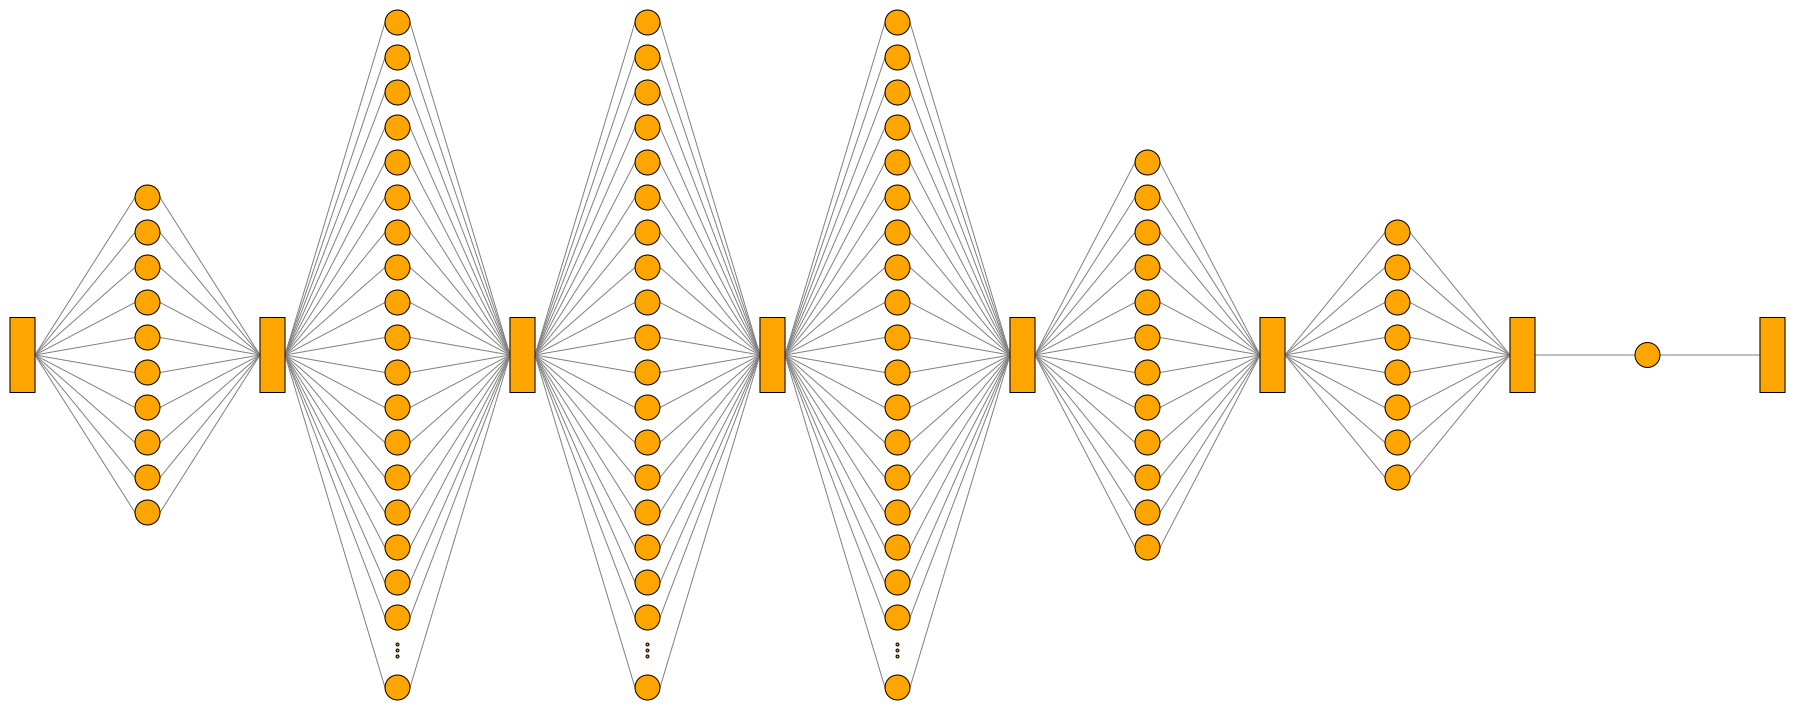

In [35]:
visualkeras.graph_view(model,node_size=25,layer_spacing=100,ellipsize_after=20)

### Learning

In [ ]:
#try:
model.fit(x_train,y_train,
              epochs=400,batch_size=131072,
              class_weight={0:.998,1:0.002},
              callbacks=[backup_callback,tensorboard_callback,
                         sig_callback(model,x_test,dtset_test['type'].values,
                                      cs_corr,'test',np.asarray(total_events)*0.5),
                         sig_callback(model,dtset.T[:-2].T,dtset['type'].values,
                                      cs_corr,'complete',np.asarray(total_events))],
              )

#except:
#    pass

The test significance is :  0.052588126011029517
The complete significance is :  0.05256481965536216
Epoch 1/400
47/47 [==============================] - 6s 89ms/step - loss: 0.2955 - accuracy: 0.8823
The test significance is :  0.06742729933958656
The complete significance is :  0.06706440680187115
Epoch 2/400
47/47 [==============================] - 4s 91ms/step - loss: 0.1525 - accuracy: 0.9372
The test significance is :  0.418098428044598
The complete significance is :  0.4187005290831167
Epoch 3/400
47/47 [==============================] - 4s 87ms/step - loss: 0.1016 - accuracy: 0.9301
The test significance is :  0.62397672282372
The complete significance is :  0.6351202775834097
Epoch 4/400
47/47 [==============================] - 4s 87ms/step - loss: 0.0758 - accuracy: 0.9165
The test significance is :  0.7619793557043044
The complete significance is :  0.7611059143581609
Epoch 5/400
47/47 [==============================] - 4s 87ms/step - loss: 0.0595 - accuracy: 0.9050
The test

### Analysis

In [ ]:
model_max.save(model_dir + "dnn_max" + str(mn2))

In [37]:
sig_comp = pd.DataFrame([[int(i+1) for i in range(len(sig_epoch['complete']))],
                          sig_epoch['test'],sig_epoch['complete']]).T
sig_comp.rename(columns = {0:'Epoch',1:'Test Sig',2:'Comp Sig'}, inplace = True)

In [38]:
max_sig

inf

In [39]:
sig_comp[sig_comp['Epoch']%30==0].style.hide_index()

Epoch,Test Sig,Comp Sig
30.000000,1.791829,1.731261
60.000000,3.139073,2.806452
90.000000,3.207027,3.227954
120.000000,3.481927,2.826174
150.000000,3.284998,2.666533
180.000000,3.625550,3.033373
210.000000,3.245518,2.785798
240.000000,4.291369,4.926378
270.000000,3.410817,3.749555
300.000000,4.020870,4.421793


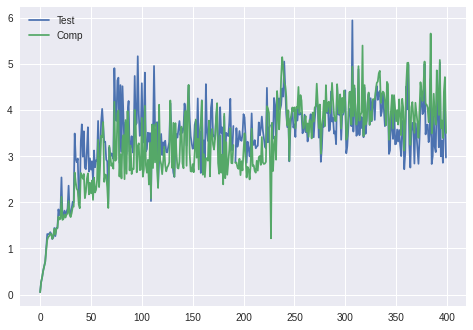

In [40]:
plt.plot(sig_comp['Test Sig'])
plt.plot(sig_comp['Comp Sig'])
plt.legend(['Test','Comp'])
plt.show()

In [41]:
pred_set = dtset.copy()
pred_set['pred'] = model.predict(pred_set.T[:-2].T,batch_size = 4096,verbose=True)

2961/2961 [==============================] - 6s 2ms/step


In [42]:
print('Correctly identified signal (True Positive)     : ',len(pred_set[pred_set['pred'] >= 0.5][pred_set['tag'] == 1]))
print('Falsely identified signal (Flase Positive)      : ',len(pred_set[pred_set['pred'] >= 0.5][pred_set['tag'] == 0]))
print('Correctly identified background (True Negative) : ',len(pred_set[pred_set['pred'] < 0.5][pred_set['tag'] == 0]))
print('Falsely identified background (False Negative)  : ',len(pred_set[pred_set['pred'] < 0.5][pred_set['tag'] == 1]))

Correctly identified signal (True Positive)     :  915070
Falsely identified signal (Flase Positive)      :  718
Correctly identified background (True Negative) :  8905039
Falsely identified background (False Negative)  :  2304804


In [43]:
print('The amount of signal left is     :', len(pred_set[pred_set['pred'] >= 0.5][pred_set['tag'] == 1])/len(df[-1]))
print('The amount of background left is :', len(pred_set[pred_set['pred'] >= 0.5][pred_set['tag'] == 0])/np.sum([len(i) for i in df[:-1]]))

NameError: name 'df' is not defined

In [44]:
print('Thus, the rate of correct signal prediction is : ',len(pred_set[pred_set['pred'] >= 0.5][pred_set['tag'] == 1])/(len(pred_set[pred_set['pred'] >= 0.5])))

Thus, the rate of correct signal prediction is :  0.999215975749846


In [45]:
L = 3000

In [46]:
print('Thus, the rate of correct signal prediction is : ',len(pred_set[pred_set['pred'] >= 0.5][pred_set['tag'] == 1])/(len(pred_set[pred_set['pred'] >= 0.5])))

Thus, the rate of correct signal prediction is :  0.999215975749846


In [47]:
ns = cs_corr['n2n2']*(len(pred_set[pred_set['pred'] >= 0.7][pred_set['tag'] == 1])/(total_events[-1]))*L
print('n2n2',cs_corr['n2n2'],(len(pred_set[pred_set['pred'] >= 0.7][pred_set['tag'] == 1])))
nb = 0

for i in range(len(files)-1):
    nb += cs_corr[files[i]]*(len(pred_set[pred_set['pred'] >= 0.7][pred_set['tag'] == 0][pred_set['type'] == i])/((total_events[i])))*L
    print(files[i],len(pred_set[pred_set['pred'] >= 0.7][pred_set['tag'] == 0][pred_set['type'] == i]),cs_corr[files[i]])

n2n2 0.24100000000000002 682570
ttbar 7 6538.845366086956
wmp 16 91227.27272727272
wpwm 89 692.2567850586979
zwpm 131 199.5908264705882


In [48]:
print('The number of signal is :', ns)
print('The number of background is :', nb)
print('The significance is :',ns/np.sqrt(nb))

The number of signal is : 126.53797692307691
The number of background is : 1208.967459526173
The significance is : 3.6392641638183143


In [90]:
model.save(model_dir + "dnn")

2022-04-21 19:42:18.332973: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /home2/kalp_shah/neutrino/datasets/model/dnn/assets


In [28]:
import tensorflow_probability as tfp
cor = tfp.stats.correlation(dtset.values[:-2,:-2])

In [29]:
for i in range(len(cor)):
    for j in range(len(cor[i])):
        if cor[i,j] > 0.8 and i!=j:
            print(dtset.keys()[i],dtset.keys()[j],cor[i,j].numpy())

ptj energyj 0.8332972254692859
energyj ptj 0.8332972254692859


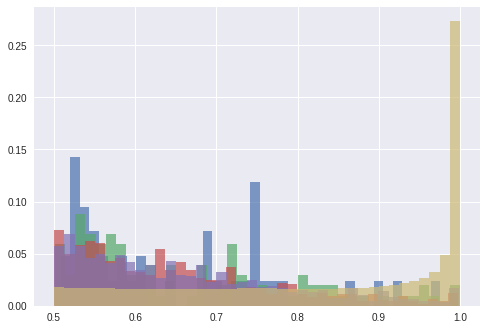

In [114]:
for i in range(len(files)):
    data = pred_set[pred_set["type"] == i][pred_set["pred"]>=0.5]["pred"].values
    plt.hist(data,alpha=0.7,bins=40,weights=np.ones_like(data)/len(data))
plt.show()